#Necessary imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Model Definition

##Model_1

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # Adjust mid_channels here after concatenation to handle the input channels correctly
            self.conv = DoubleConv(in_channels + in_channels // 2, out_channels, in_channels)  # in_channels + in_channels // 2 because of concatenation
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Handling the size mismatch
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)  # This causes the channel count to double
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class DUCKNet(nn.Module):
    def __init__(self, img_height, img_width, input_channels, out_classes, starting_filters, bilinear=True):
        super(DUCKNet, self).__init__()
        self.inc = DoubleConv(input_channels, starting_filters)
        self.down1 = Down(starting_filters, starting_filters * 2)
        self.down2 = Down(starting_filters * 2, starting_filters * 4)
        self.down3 = Down(starting_filters * 4, starting_filters * 8)
        self.down4 = Down(starting_filters * 8, starting_filters * 16)
        self.down5 = Down(starting_filters * 16, starting_filters * 32)

        self.up1 = Up(starting_filters * 32, starting_filters * 16, bilinear)
        self.up2 = Up(starting_filters * 16, starting_filters * 8, bilinear)
        self.up3 = Up(starting_filters * 8, starting_filters * 4, bilinear)
        self.up4 = Up(starting_filters * 4, starting_filters * 2, bilinear)
        self.up5 = Up(starting_filters * 2, starting_filters, bilinear)

        self.outc = OutConv(starting_filters, out_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        x = self.up1(x6, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        logits = self.outc(x)
        return logits


In [6]:
img_height = 256
img_width = 256
input_channels = 1
out_classes = 1
starting_filters = 64

model = DUCKNet(img_height, img_width, input_channels, out_classes, starting_filters)


##Model_2

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024 // (2 if bilinear else 1))
        self.up1 = Up(1024, 512 // (2 if bilinear else 1), bilinear)
        self.up2 = Up(512, 256 // (2 if bilinear else 1), bilinear)
        self.up3 = Up(256, 128 // (2 if bilinear else 1), bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [ ]:
model = UNet(n_channels=1, n_classes=1)

#Loading Model_1

In [7]:
img_height = 256
img_width = 256
input_channels = 1
out_classes = 1
starting_filters = 64

model = DUCKNet(img_height, img_width, input_channels, out_classes, starting_filters)

model_path = '/content/drive/MyDrive/Origin_Medical/duck_model_weights.pth'
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

#Predicting Output Mask

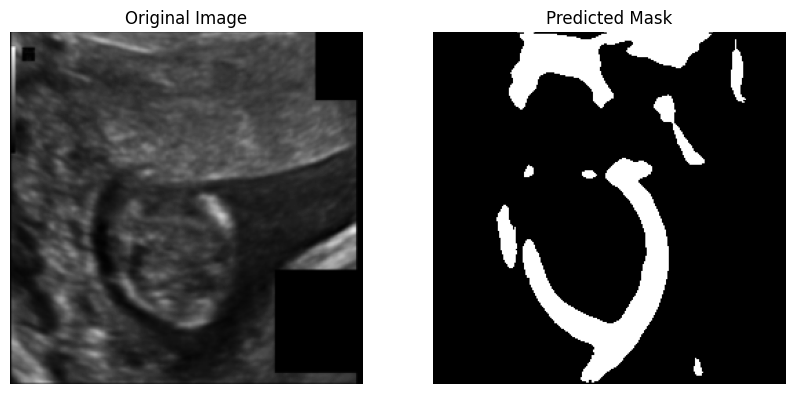

In [8]:
def visualize_segmentation(image, prediction, threshold=0.002):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image.squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(prediction.squeeze() > threshold, cmap='gray')
    axes[1].set_title('Predicted Mask')
    for ax in axes:
        ax.axis('off')
    plt.show()


image_path = "/content/drive/MyDrive/Origin_Medical/Task - Segmentation/images/008_HC.png"
image = Image.open(image_path).convert("L")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
input_image = transform(image).unsqueeze(0)

input_image = input_image.to(device)

model.eval()

with torch.no_grad():
    output = model(input_image)
    prediction = torch.sigmoid(output)

visualize_segmentation(input_image.squeeze().cpu(), prediction.squeeze().cpu())


In [9]:
!mkdir predicted_images

# Convert the prediction to a NumPy array and scale it to the range [0, 255]
prediction_array = (prediction.squeeze().cpu().numpy() * 255).astype(np.uint8)

plt.imsave('/content/predicted_images/predicted_image.png', prediction_array, cmap='gray')


In [ ]:
prediction.shape

torch.Size([1, 1, 256, 256])

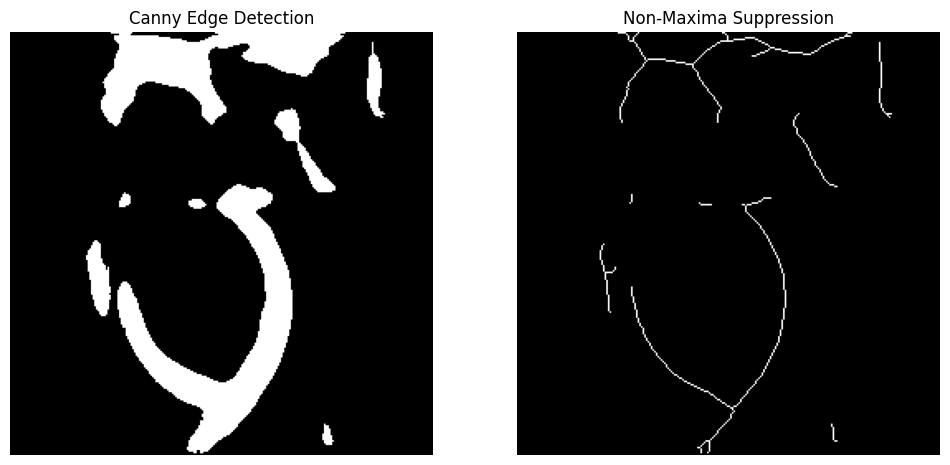

In [10]:
from skimage.morphology import thin
perdiction_img = (prediction.squeeze() > 0.002).cpu()
# Applying non-maxima suppression through thinning in skimage
thinned_edges = thin(perdiction_img)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(perdiction_img, cmap='gray')
axes[0].set_title('Canny Edge Detection')
axes[0].axis('off')

axes[1].imshow(thinned_edges, cmap='gray')
axes[1].set_title('Non-Maxima Suppression')
axes[1].axis('off')

plt.show()

#Fitting ellipse on predicted mask and getting biometric point


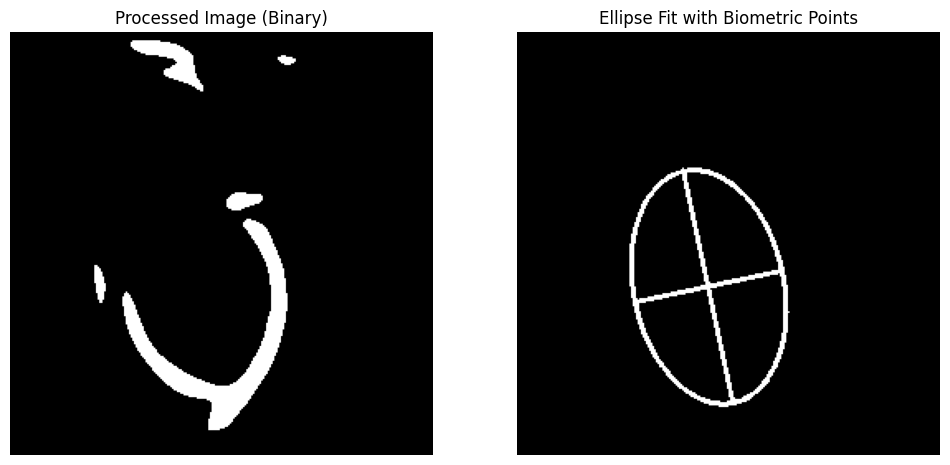

[(130, 223), (100, 83)] [(71, 163), (160, 144)]


In [11]:
processed_image_path = '/content/predicted_images/predicted_image.png'
processed_image = Image.open(processed_image_path)

# binary for contour detection
processed_image_np = np.array(processed_image.convert('L'))
_, binary_processed = cv2.threshold(processed_image_np, 25, 255, cv2.THRESH_BINARY)
contours_processed, _ = cv2.findContours(binary_processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Assume the largest contour is the target contour
contours_processed = sorted(contours_processed, key=cv2.contourArea, reverse=True)
target_contour = contours_processed[0] if contours_processed else None

# Fit an ellipse
if target_contour is not None and len(target_contour) >= 5:  # Minimum points required to fit ellipse
    ellipse = cv2.fitEllipse(target_contour)
    ellipse_image = np.zeros_like(binary_processed)
    cv2.ellipse(ellipse_image, ellipse, (255, 255, 255), 2)

    center, axes, angle = ellipse
    major_axis_endpoints = [
        (int(center[0] + axes[1]/2 * np.sin(np.radians(angle))), int(center[1] - axes[1]/2 * np.cos(np.radians(angle)))),
        (int(center[0] - axes[1]/2 * np.sin(np.radians(angle))), int(center[1] + axes[1]/2 * np.cos(np.radians(angle))))]

    minor_axis_endpoints = [
        (int(center[0] + axes[0]/2 * np.cos(np.radians(angle))), int(center[1] + axes[0]/2 * np.sin(np.radians(angle)))),
        (int(center[0] - axes[0]/2 * np.cos(np.radians(angle))), int(center[1] - axes[0]/2 * np.sin(np.radians(angle))))]

    cv2.line(ellipse_image, major_axis_endpoints[0], major_axis_endpoints[1], (255, 255, 255), 2)
    cv2.line(ellipse_image, minor_axis_endpoints[0], minor_axis_endpoints[1], (255, 255, 255), 2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(binary_processed, cmap='gray')
    axes[0].set_title('Processed Image (Binary)')
    axes[0].axis('off')

    axes[1].imshow(ellipse_image, cmap='gray')
    axes[1].set_title('Ellipse Fit with Biometric Points')
    axes[1].axis('off')
    plt.show()


    print(major_axis_endpoints, minor_axis_endpoints)

else:

    print("Not enough points to fit an ellipse.")


## Drawing predicted biometric points on original image

In [12]:
def draw_biometric_points(image_path, major_axis_endpoints, minor_axis_endpoints):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print("Error: Image could not be loaded. Check the path.")
        return

    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    cv2.circle(image, major_axis_endpoints[0], radius=5, color=(0, 255, 0), thickness=-1)
    cv2.circle(image, major_axis_endpoints[1], radius=5, color=(0, 255, 0), thickness=-1)
    cv2.line(image, major_axis_endpoints[0], major_axis_endpoints[1], (0, 255, 0), 2)

    cv2.circle(image, minor_axis_endpoints[0], radius=5, color=(255, 0, 0), thickness=-1)
    cv2.circle(image, minor_axis_endpoints[1], radius=5, color=(255, 0, 0), thickness=-1)
    cv2.line(image, minor_axis_endpoints[0], minor_axis_endpoints[1], (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Image with Biometric Points')
    plt.axis('off')
    plt.show()

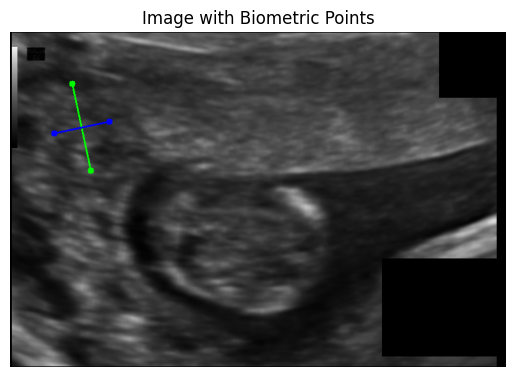

In [13]:
image_path = '/content/drive/MyDrive/Origin_Medical/Task - Segmentation/images/008_HC.png'
major_axis_endpoints = [(130, 223), (100, 83)]
minor_axis_endpoints = [(71, 163), (160, 144)]
draw_biometric_points(image_path, major_axis_endpoints, minor_axis_endpoints)

## Again rescaling predicted points to original image dimensions

In [19]:
def scale_points_to_original_size(points, original_size, transformed_size=(256, 256)):
    original_width, original_height = original_size
    transformed_width, transformed_height = transformed_size

    scale_x = original_width / transformed_width
    scale_y = original_height / transformed_height

    scaled_points = [(int(x * scale_x), int(y * scale_y)) for x, y in points]
    return scaled_points

In [25]:
from PIL import Image
def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
       width, height  = img.size
    return (width, height)

Image dimensions: (800, 540)
Major Axis Endpoints on Original: [(406, 470), (312, 175)]
Minor Axis Endpoints on Original: [(221, 343), (500, 303)]


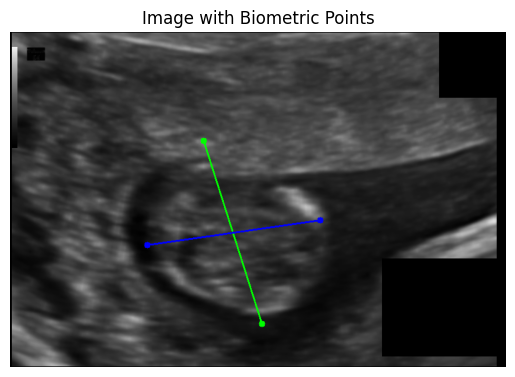

In [26]:
image_path = "/content/drive/MyDrive/Origin_Medical/Task - Segmentation/images/008_HC.png"
original_size = get_image_dimensions(image_path)
print(f"Image dimensions: {original_size}")

major_axis_endpoints = major_axis_endpoints
minor_axis_endpoints = minor_axis_endpoints

# Scale points to original size
major_axis_endpoints_original = scale_points_to_original_size(major_axis_endpoints, original_size)
minor_axis_endpoints_original = scale_points_to_original_size(minor_axis_endpoints, original_size)
print("Major Axis Endpoints on Original:", major_axis_endpoints_original)
print("Minor Axis Endpoints on Original:", minor_axis_endpoints_original)
draw_biometric_points(image_path, major_axis_endpoints_original, minor_axis_endpoints_original)